In [1]:
from visualizer import get_local
get_local.activate()

In [2]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts as CAWR
from models.BiFPN_2_CSPIformer import BiFPNDecoder
from models.CSP_IFormer_final_SegMode import iformer_small
from models import LoRA_create, Vit_create, IncepFormer
# from models.IncepFormer import IncepFormer, Block
from util.tool import CreateNewFile, CreateNF, check_dataset, check_checkpoint, cls_check_checkpoint, show_img, train, validate, test, train_cls, val_cls, test_cls, test_, att_map
from util.train import CSPIformer2BiFPN
from models.CSWin import CSWin_64_12211_tiny_224

In [3]:
import numpy as np
import torch, os, time, random
import albumentations as A
# import sklearn.metrics as skm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet18
from albumentations.pytorch import ToTensorV2
from torch.nn.utils.rnn import pad_sequence
from IPython.display import clear_output
from thop import profile, clever_format
from torch.utils.data import DataLoader
# from models.Vit_create import ViT
from torchsummary import summary
# from sklearn.metrics import confusion_matrix, classification_report
# from datetime import datetime
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [4]:
# def setup_seed(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
# # 设置随机数种子
# setup_seed(3407)

In [5]:
batch_size, epoch, lr, dropout, emb_dropout = 8, 100, 9e-4, 0.1, 0.1
# If win_sizes is't None, will set the CSFormer self-attention of split_sizes(8)
img_size, patch_size, win_sizes, split_sizes = (256, 256), 16, None, 8
# If dataset didn't split training, validation and testing, you can set the ratio of them (0.8, 0.1)
ratio_train, ratio_val = None, None
# 'EDPaths' have two weights to pretrained, 'pretrain' is add LoRA to finetune
# ImageLabel: {0: text label, 1: mask label, 2: non label, 3: mask label in different file}
ImageLabel, EDPaths, TFPreT = 0, False, False
# set Q, K, V and rank to do in LoRA
AddQKV, rank, requ_grad = ['q', 'v'], 4, False
# choose the model (int): 
# 0 → ViT_Base, 1 → ViT_Large, 2 → ViT_Huge, 
# 3 → IncepTransformer_T, 4 → IncepTransformer_S, 5 → IncepTransformer_B, 
# 6 → IFormer_small + BiFPNDecoder, 7 → ResNet18
mod_num = 6
# choose the data (int):  0 → cat_dog, 1 → barrett, 2 → brain_bleeding, 3 → Birds, 4 → Retinal, 5 → Chest_Pneumonia, 6 → Brain_Tumor, 7 → aocr2024
data_num = 3
# different dataset of num_class (int): cat_dog → 2 , barrett → 4, brain_bleeding → 2, Birds → 100 or 325, Retinal → 2, Chest_Pneumonia → 2, Brain_Tumor → 3
num_class = 100

model_list = ['ViT_Base', 'ViT_Large', 'ViT_Huge', 'IPT_T', 'IPT_S', 'IPT_B', 'IFormer_S', 'resnet18']
mod_name = model_list[mod_num]
data_list = ['cat_dog', 'barrett', 'brain_bleeging', 'Birds_Species', 'Retinal_Glaucoma', 'Chest_Pneumonia', 'Brain_Tumor', 'aocr2024']
data_name = data_list[data_num]
assert (data_name == 'cat_dog' and ImageLabel == 0 and num_class == 2) or (data_name == 'barrett' and ImageLabel == 1 and num_class == 4) or (data_name == 'brain_bleeging' and ImageLabel == 1 and num_class == 2) or (data_name == 'Birds_Species' and ImageLabel == 0 and num_class <= 325) or (data_name == 'Retinal_Glaucoma' and ImageLabel == 0 and num_class == 2) or (data_name == 'Chest_Pneumonia' and ImageLabel == 0 and num_class == 2) or (data_name == 'Brain_Tumor' and ImageLabel == 0 and num_class == 3) or (data_name == 'aocr2024' and (ImageLabel == 0 or ImageLabel == 3) and num_class == 2), 'You should check the data_name, ImageLabel and num_class'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# check & set the used model
if mod_name == 'ViT_Base':
    dim, depth = 768, 12
    print(f"used: {mod_name}")
elif mod_name == 'ViT_Large':
    dim, depth = 1024, 24
    print(f"used: {mod_name}")
elif mod_name == 'ViT_Huge':
    dim, depth = 1280, 32
    print(f"used: {mod_name}")
elif mod_name == 'IPT_T':
    dim, depth = 512, [2, 2, 4, 2]
    print(f"used: {mod_name}")
elif mod_name == 'IPT_S':
    dim, depth = 768, [3, 4, 12, 3]
    print(f"used: {mod_name}")
elif mod_name == 'IPT_B':
    dim, depth = 768, [3, 6, 24, 2]
    print(f"used: {mod_name}")

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_path = '.\\dataset\\input_img\\' + f'{data_name}\\'
output_path = '.\\dataset\\output_img\\'
train_path = output_path + "train\\"
test_path = output_path + f"{mod_name}_test\\"
CreateNF(train_path)

In [20]:
test_path = CreateNewFile(output_path + f"{mod_name}_test\\")
weight_path = CreateNewFile(output_path + f'weight_{mod_name}\\')

In [8]:
pretrain_path = output_path + "pretrain_weight\\" + "epoch0074_F1_0.9138_best.pth"
p1 = output_path + "pretrain_weight\\" + "best_REC_encoder.pth"
p2 = output_path + "pretrain_weight\\" + "best_REC_decoder.pth"
Checkpoint_path = output_path + f'checkpoint_{mod_name}\\'
CreateNF(Checkpoint_path)
loss = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)
# loss = torch.nn.CrossEntropyLoss()

In [9]:
# # For segmentation
# train_transform = A.Compose([
#     A.Resize(img_size[0], img_size[1]),
#     A.Normalize(mean = [0.485, 0.456, 0.406],
#                             std = [0.229, 0.224, 0.225]),
#     # A.HorizontalFlip(p = 0.5),
#     # A.VerticalFlip(p = 0.5),
#     # A.ColorJitter(brightness = 0.4, contrast = 0.4, saturation = 0.4, hue = 0.4),
#     A.RandomRotate90(),
#     ToTensorV2(),
# ])
# valtest_transform = A.Compose([
#     A.Resize(img_size[0], img_size[1]),
#     A.Normalize(mean = [0.485, 0.456, 0.406],
#                             std = [0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [10]:
def _my_normalization(x):
    return Image.open(x).convert('RGB')


In [11]:
# For classification
train_transform = transforms.Compose([  # 將圖片轉化成tensor
    transforms.Lambda(_my_normalization),  # string path => image data
    transforms.Resize(size=(img_size[0], img_size[1])),
    # transforms.ToPILImage(),
    # 資料增強
    # transforms.Resize((img_size, img_size)),
    # transforms.Resize(
    #     (int(img_size), int(img_size))),
    transforms.RandomCrop(size=(img_size[0], img_size[1])),
    transforms.RandAugment(),
    transforms.ColorJitter(0.4,0.4,0.4,0.4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])
valtest_transform = transforms.Compose([  # 將圖片轉化成tensor
    # string path => image data
    transforms.Lambda(_my_normalization),
    transforms.Resize((img_size[0], img_size[1])),
    transforms.ToTensor(),
])

In [12]:
# setting train, validation and test data 
train_dataset = check_dataset(input_path, img_size, 'train', train_transform, ImageLabel, classnum = num_class, ratio_train = ratio_train, ratio_val = ratio_val)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)

val_dataset = check_dataset(input_path, img_size, 'val', valtest_transform, ImageLabel, classnum = num_class, ratio_train = ratio_train, ratio_val = ratio_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, pin_memory = True)

# test_dataset = check_dataset(input_path, img_size, 'test', valtest_transform, ImageLabel, classnum = num_class, ratio_train = ratio_train, ratio_val = ratio_val)
# test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory=True)
print(f"train dataset: {len(train_dataset)}, val dataset: {len(val_dataset)}")
print(f"train loader: {len(train_loader)}, val loader: {len(val_loader)}")

train dataset: 14500, val dataset: 500
train loader: 1813, val loader: 63


In [13]:
# def loader_img(img, label):
#     # 轉換 PyTorch 張量為 NumPy 數組
#     input_img = img.cpu().numpy().transpose((1, 2, 0))
#     if ImageLabel:
#         label_img = label.cpu().numpy()
#         # 顯示圖像和分割圖
#         fig, ax = plt.subplots(1, 2, figsize = (10, 5))
#         ax[0].set_title('input image')
#         ax[0].xaxis.set_visible(False)
#         ax[0].yaxis.set_visible(False)
#         ax[0].imshow(input_img)
#         ax[1].set_title('label image')
#         ax[1].xaxis.set_visible(False)
#         ax[1].yaxis.set_visible(False)
#         ax[1].imshow(label_img)
#         plt.show()
#     else:
#         plt.figure(figsize = (10, 5))
#         plt.title(f"class_{label}")
#         plt.axis('off')
#         plt.imshow(input_img)
#         plt.show()

In [14]:
# # print input images and label images
# i = 0
# for imgs, labels in train_loader:
#     input_img = imgs[0]
#     target_img = labels[0]
#     loader_img(input_img, target_img)
#     if i == 1:
#         break
#     i += 1

In [15]:
# import zipfile
# import os

# # Replace 'your_file.sip' with your .sip file path
# sip_file_path = '.\\dataset\\input_img\\aocr2024\\TrainValid_Mask.sip'
# extract_to_folder = '.\\dataset\\input_img\\aocr2024\\TrainValid_Mask\\'

# # Check if the .sip file is a ZIP file
# if zipfile.is_zipfile(sip_file_path):
#     with zipfile.ZipFile(sip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to_folder)
#     print(f"Images extracted to folder: {extract_to_folder}")
# else:
#     print("The file is not a ZIP archive or not readable as such.")

In [16]:
# from PIL import Image
# import gzip, io
# extract_to_folder_ = extract_to_folder + '3_Test1_Image'
# for filename in os.listdir(extract_to_folder_):
#     if filename.endswith('.gz'):
#         gz_path = os.path.join(extract_to_folder_, filename)
#         print(f"Showing image: {gz_path}")
#         with gzip.open(gz_path, 'rb') as f:
#             print(f)
#             with Image.open(io.BytesIO(f.read())) as img:
#                 img.show()
        

In [12]:
def CheckModel():
    if mod_num == 6:
        print(f"Model: {mod_name}")
        return CSPIformer2BiFPN(img_size[0], num_class, [96, 192, 320, 384], win_sizes = win_sizes, split_sizes = split_sizes, ImageLabel = ImageLabel).to(device)
        # return BiFPNDecoder([96, 192, 320, 384], iformer_small(size = img_size[0], add_lora = addRoLA, num_classes = num_class)).to(device)
        # return CSWin_64_12211_tiny_224().to(device)
    elif mod_num == 7:
        print(f"Model: {mod_name}")
        return resnet18(num_classes = num_class).to(device)
    elif mod_num == 3 or 4 or 5:
        print(f"Model: {mod_name}")
        return IncepFormer.IncepFormer(size = img_size, out_ = dim, depth = depth, num_class = num_class, For_seg = ImageLabel).to(device)
    elif mod_num == 0 or 1 or 2:
        print(f"Model: {mod_name}")
        return Vit_create.ViT(img_size = img_size, num_class = num_class, dim = dim, depth = depth, dropout = dropout, emb_dropout = emb_dropout).to(device)

In [13]:
def model_opt():
    model = CheckModel()
    # optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = CAWR(optimizer, T_0 = 5, T_mult = 2)
    return model, optimizer, scheduler

In [ ]:
# setting the fine tune's pretrain model & weights
def check_FT(**kwargs):
    base_model = CheckModel()
    for key, value in kwargs.items():
        if key == 'path':
            pth = value
            print(f"finishing loading base model weight.")
            state_dict = torch.load(pth)
            base_model.load_state_dict(state_dict, strict = True)
        elif key == 'path_1':
            pth = value
            print(f"finishing loading base model's encoder weights.")
            state_dict = torch.load(pth)
            base_model.encoder.load_state_dict(state_dict, strict = True)
        elif key == "path_2":
            pth = value
            print(f"finishing loading base model's decoder weights.")
            state_dict = torch.load(pth)
            base_model.decoder.load_state_dict(state_dict, strict = True)
    model = LoRA_create.LoRA_MHSA(base_model, r = rank, stage = 4, add_ = AddQKV, requ_grad = requ_grad).to(device)
    # print(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = CAWR(optimizer, T_0 = 5, T_mult = 2)
    return model, optimizer, scheduler

In [ ]:
# setting the original model & weights
def check_ORI(**kwargs):
    model = CheckModel()
    for key, value in kwargs.items():
        if key == 'path':
            pth = value
            print(f"finishing loading base model weight.")
            state_dict = torch.load(pth)
            model.load_state_dict(state_dict, strict = True)
        elif key == 'path_1':
            pth = value
            print(f"finishing loading base model's encoder weights.")
            state_dict = torch.load(pth)
            model.encoder.load_state_dict(state_dict, strict = True)
        elif key == "path_2":
            pth = value
            print(f"finishing loading base model's decoder weights.")
            state_dict = torch.load(pth)
            model.decoder.load_state_dict(state_dict, strict = True)
    # model = LoRA_create.LoRA_MHSA(model, r = rank, stage = 4, add_ = AddQKV).to(device)
    # print(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
    scheduler = CAWR(optimizer, T_0 = 5, T_mult = 2)
    return model, optimizer, scheduler

In [13]:
# model = ViT(img_size = img_size, patch_size = patch_size, num_class = num_class, dim = dim, depth = depth, head = head, mlp_dim = mlp_dim, dropout = dropout, emb_dropout = emb_dropout).to(device)
# model = IncepFormer(size = img_size, out_ = dim, depth = depth, num_class = num_class, For_seg = ImageLabel, RoLA_ = addRoLA).to(device)
model = CheckModel()
print(model)
# print(CSPIformer2BiFPN(img_size[0], addRoLA, num_class, [96, 192, 320, 384]))
# model = IncepTransformer_T(depths = depth)
summary(model, (3, img_size[0], img_size[1]))

Model: IFormer_S
CSPIformer2BiFPN(
  (encoder): InceptionTransformer(
    (patch_embed): IFormer_FirstPatchEmbed(
      (proj1): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu1): GELU(approximate='none')
      (proj2): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (blocks1): CSP_IFomerBlock(
      (dense): Sequential(
        (0): IFormer_Block(
          (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
          (attn): CSP_Inception_token_mixer(
            (high_mixer): HighMixer(
              (conv1): Conv2d(12, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (proj1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
              (mid_gelu1): GELU(approximate='none')

AttributeError: 'list' object has no attribute 'size'

In [ ]:
# res, win_size = 14, 7
# ten = torch.arange(res**2).reshape(res, res)
# p1 = (res - win_size) // 2
# p2 = res - p1 - win_size
# print(p1, p2)
# print(f"ten: {ten.shape}")
# L_, cen, R_ = ten.split([p1, win_size, p2], dim = 1)
# print(f"Ori: {cen.shape}")
# U_, C_, D_ = cen.split([p1, win_size, p2], dim = 0)
# print(C_.shape)
# print(C_)
# a = torch.cat([L_, torch.cat([U_, C_, D_], dim = 0), R_], dim = 1)
# print(f"after{a.shape}")
# print(a)
# # print(ten.tensor_split(3, dim = -1))

In [ ]:
# graph model
from torchview import draw_graph
import graphviz
# graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size = (1, 3, img_size[0], img_size[1]), expand_nested = True)
# device='meta' -> no memory is consumed for visualization
model_graph.visual_graph

# Semantic Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----------------------------Epoch 0100|0100-----------------------------
Learning rate: 0.0008991531508050671
train epoch time:2.4289557933807373s


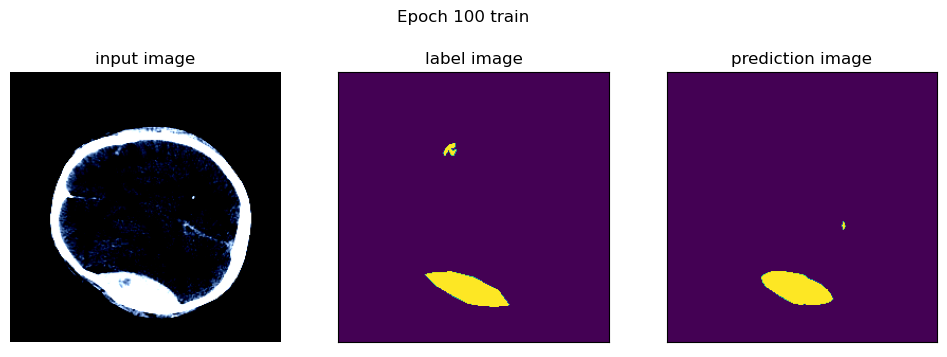

valid epoch time:0.41509270668029785s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


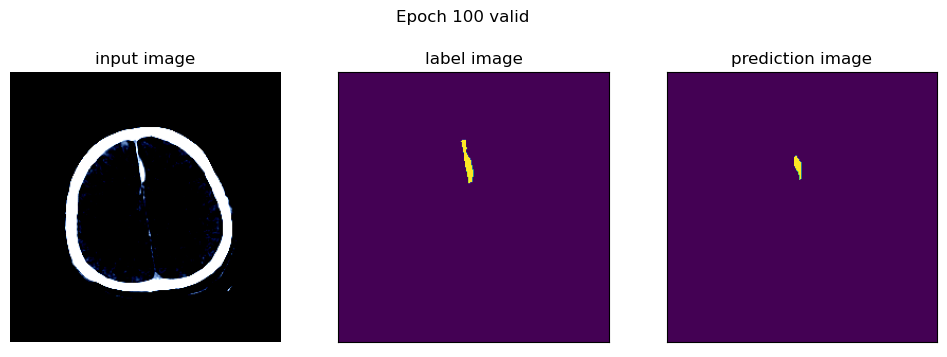

Different Metrics were:  {'Specificity': 0.9657953148772822, 'Senstivity': 0.9657953148772822, 'F1': 0.8635331995494192, 'Precision': 0.7808542483888992, 'Pixel_Accuracy': 0.9823521205346436, 'IoU': array([0.98196912, 0.54620106]), 'MIoU': 0.7640850900852048, 'FWIoU': 0.9655254193696144, 'acc': 0.9819723765055339, 'js': 0.9645966278266861}
last best F1: 0.8777128099588054 vs. current F1: 0.8635331995494192
model saved successfully at .\dataset\output_img\checkpoint_IFormer_S\model_checkpoint_brain_bleeging.tar


In [15]:
if __name__ == "__main__":
    best_F1 = 0
    # to hold loss values after each epoch
    loss_all_epochs = []
    # to hold different metrics after each epoch
    Specificity_ = []
    Senstivity_ = []
    F1_ = []
    acc_ = []
    js_ = []
    LearnRate = []
    train_time, val_time = [], []
    # epoch_continue = 0
    if TFPreT:
        # For training fine tune model
        if EDPaths:
            model, optimizer, scheduler = check_FT(path_1 = p1, path_2 = p2)
        else: 
            model, optimizer, scheduler = check_FT(path = pretrain_path)
    else:
        # For training original model
        if EDPaths:
            # training base on EDPaths Weights
            model, optimizer, scheduler = check_ORI(path_1 = p1, path_2 = p2)
        else:
            model, optimizer, scheduler = model_opt()
    # check the checkpoint
    model, optimizer, scheduler, epoch_continue, best_F1, weight_path, tr_time, v_time = check_checkpoint(model, optimizer, scheduler, weight_path, Checkpoint_path = Checkpoint_path, data_name = data_name)
    print(f"weight saved as : {weight_path}...")
    for epoch_i in range(epoch - epoch_continue):
        # training
        print(
            f"-----------------------------Epoch {epoch_i + 1 + epoch_continue:04d}|{epoch:04d}-----------------------------")
        t1 = time.time()
        input_img, target_img, pred_img, loss_i = train(train_loader, model, optimizer, epoch_i + 1 + epoch_continue, epoch, scheduler, ImageLabel)
        loss_all_epochs.append(loss_i)
        print(f"losss: {loss_i}")
        t2 = time.time()

        # metrics calculation on validation data
        t3 = time.time()
        val_input, val_mask, val_pred, dummy_list = validate(val_loader, model, epoch_i + 1 + epoch_continue, epoch, num_class)
        t4 = time.time()

        clear_output(wait = True)
        print(
            f"-----------------------------Epoch {epoch_i + 1 + epoch_continue:04d}|{epoch:04d}-----------------------------")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        LearnRate.append(optimizer.param_groups[0]['lr'])
        print(f"train epoch time:{t2 - t1}s")
        train_time.append(t2 - t1)
        show_img(epoch_i + epoch_continue + 1, input_img, target_img, pred_img, 'train', num_class, train_path)
        print(f"valid epoch time:{t4 - t3}s")
        val_time.append(t4 - t3)
        show_img(epoch_i + epoch_continue + 1, val_input, val_mask, val_pred, 'valid', num_class, train_path)
        print("Different Metrics were: ", dummy_list)
        
        # scheduler.step()
        print(f"last best F1: {best_F1} vs. current F1: {dummy_list['F1']}")
        if dummy_list["F1"] > best_F1:
            best_F1 = dummy_list["F1"]
            print(f'best F1: {best_F1}')
            torch.save(
                model.state_dict(), f'{weight_path}{data_name}_epoch{epoch_i + 1 + epoch_continue:04d}_f1_{best_F1:.4f}_best.pth')
            print(f'save weights...{weight_path}')
        if epoch_i == (epoch - 1 - epoch_continue):
            torch.save(model.state_dict(), f'{weight_path}{data_name}_epoch{epoch_i + 1 + epoch_continue:04d}_f1_{dummy_list["F1"]:.4f}_last.pth')
        # save model Checkpoint
        torch.save({
            'epoch': epoch_i + 1 + epoch_continue,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler != None else scheduler,
            'best_F1score': best_F1,
            'weight_path': weight_path,
            'train_time': train_time,
            'val_time': val_time,
        }, f"{Checkpoint_path}model_checkpoint_{data_name}.tar")
        print(f"model saved successfully at {Checkpoint_path}model_checkpoint_{data_name}.tar")

        # Add metrics to empty list above
        Specificity_.append(dummy_list["Specificity"])
        Senstivity_.append(dummy_list["Senstivity"])
        F1_.append(dummy_list["F1"])
        acc_.append(dummy_list["acc"])
        js_.append(dummy_list["js"])


In [16]:
print(f"all F1 scores: {F1_}, all acc scores: {acc_}, all js scores: {js_}")

all F1 scores: [0.4995164746201768, 0.4995164746201768, 0.4995164746201768, 0.4995164746201768, 0.4995164746201768], all acc scores: [0.9980717081772653, 0.9980717081772653, 0.9980717081772653, 0.9980717081772653, 0.9980717081772653], all js scores: [0.9961520648708536, 0.9961520648708536, 0.9961520648708536, 0.9961520648708536, 0.9961520648708536]


# Seg. Test

In [16]:
test_dataset = check_dataset(input_path, img_size, 'test', valtest_transform, ImageLabel)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory = True)
if TFPreT:
    model, optimizer, scheduler = check_FT()
else:
    # Barrett Base
    # model, optimizer, scheduler = check_ORI(path = ".\\dataset\\output_img\\pretrain_weight\\epoch0191_F1_0.9396_best.pth")
    # Brain Base
    # model, optimizer, scheduler = check_ORI(path = ".\\dataset\\output_img\\pretrain_weight\\epoch0143_F1_0.9033_best.pth")
    model, optimizer, scheduler = model_opt()
model, optimizer, scheduler, epoch_continue, best_F1, weight_path, tr_time, v_time = check_checkpoint(model, optimizer, scheduler, "", Checkpoint_path = Checkpoint_path, data_name = data_name)
print(f"Total used time: {sum(tr_time) + sum(v_time)}s")
# weight_path = weight_path[:-20] + "2023_08_03_08_19_16\\"
w_path = os.path.dirname(weight_path)
weight_name = os.listdir(w_path)
best_loss = weight_name[-2]
model.load_state_dict(torch.load(f'{weight_path}{best_loss}'))
print(f'beat weight: {weight_path}{best_loss}')

Model: IFormer_S


RuntimeError: Error(s) in loading state_dict for CSPIformer2BiFPN:
	Missing key(s) in state_dict: "encoder.blocks1.f_CS.bn.weight", "encoder.blocks1.f_CS.bn.bias", "encoder.blocks1.f_CS.bn.running_mean", "encoder.blocks1.f_CS.bn.running_var", "encoder.blocks1.f_CS.conv_fus.weight", "encoder.blocks2.f_CS.bn.weight", "encoder.blocks2.f_CS.bn.bias", "encoder.blocks2.f_CS.bn.running_mean", "encoder.blocks2.f_CS.bn.running_var", "encoder.blocks2.f_CS.conv_fus.weight", "encoder.blocks3.f_CS.bn.weight", "encoder.blocks3.f_CS.bn.bias", "encoder.blocks3.f_CS.bn.running_mean", "encoder.blocks3.f_CS.bn.running_var", "encoder.blocks3.f_CS.conv_fus.weight", "encoder.blocks4.f_CS.bn.weight", "encoder.blocks4.f_CS.bn.bias", "encoder.blocks4.f_CS.bn.running_mean", "encoder.blocks4.f_CS.bn.running_var", "encoder.blocks4.f_CS.conv_fus.weight". 
	size mismatch for encoder.pos_embed1: copying a param with shape torch.Size([1, 56, 56, 96]) from checkpoint, the shape in current model is torch.Size([1, 128, 128, 96]).
	size mismatch for encoder.pos_embed2: copying a param with shape torch.Size([1, 28, 28, 192]) from checkpoint, the shape in current model is torch.Size([1, 64, 64, 192]).
	size mismatch for encoder.pos_embed3: copying a param with shape torch.Size([1, 14, 14, 320]) from checkpoint, the shape in current model is torch.Size([1, 32, 32, 320]).
	size mismatch for encoder.pos_embed4: copying a param with shape torch.Size([1, 7, 7, 384]) from checkpoint, the shape in current model is torch.Size([1, 16, 16, 384]).

In [ ]:
test_path = test_path[:-20] + weight_path[-20:]
# test_path = test_path[:-20] + "2023_08_02_17_25_44"
# test_path = test_path[:-20] + "2023_08_10_15_46_22"
print(test_path, AddQKV, f"used RoLA: {TFPreT}")
test(test_loader, model, test_path, num_class, input_path, img_size)

# MACs & Params

In [ ]:
if TFPreT:
    if EDPaths:
        model_FT, optimizer, scheduler = check_FT(path_1 = p1, path_2 = p2)
    else: 
        model_FT, optimizer, scheduler = check_FT(path = pretrain_path)

model, optimizer, scheduler = model_opt()
in_ = torch.randn(1, 3, img_size[0], img_size[1]).to(device)
flops, params = profile(model, inputs = (in_,))
if TFPreT:
    macs_FT, params_FT = profile(model_FT, inputs = (in_,))
    print(F"LoRA: FLOPs = {flops / 1e9}G, params = {(params_FT - params) / 1e6}M")
print(F"model FLOPs = {flops / 1e9}G, params = {(params) / 1e6}M")

In [ ]:
# split_size=[1,2,7,7] model FLOPs = 4.08370944G, params = 22.320552M

In [ ]:
# Block: Short-Cut =====
# CS, Ax 1st Stage model FLOPs = 1.919615232G, params = 6.295861M
# CS, CSPIFormer model FLOPs = 1.91895168G, params = 6.295141M
# New_CS, CSPIFormer model FLOPs = 2.045387008G, params = 6.462101M
# New_CS, Ax 1st Stage model FLOPs = 2.04605056G, params = 6.462821M
# Block & Stage: Short-Cut =====
# New_CS & CS, CSPIFormer model FLOPs = 0.954250496G, params = 3.128669M
# New_CS & CS, Ax 1st Stage model FLOPs = 0.954582272G, params = 3.129029M

# Classification

In [15]:
loss_all_epochs, best_acc, best_loss, all_loss, all_acc, train_time, val_time = [], 0, 100, [], [], [], []
epoch_continue = 0
model, optimizer, scheduler = model_opt()
# load the checkpoint
model, optimizer, scheduler, epoch_continue, best_loss, best_acc, weight_path, all_loss, all_acc, tr_time, v_time = cls_check_checkpoint(model, optimizer, scheduler, weight_path, Checkpoint_path = Checkpoint_path, data_name = data_name)
print(f"used time: {sum(tr_time) + sum(v_time)}s")
print(f"weight saved as : {weight_path}...")
for epoch_i in range(epoch - epoch_continue):
    # training
    print(
        f"-----------------------------Epoch {epoch_i + 1 + epoch_continue:04d}|{epoch:04d}-----------------------------")
    t1 = time.time()
    input_img, label, pred, train_loss, train_accuracy = train_cls(train_loader, model, optimizer, loss, epoch_i + 1 + epoch_continue, epoch, scheduler)
    loss_all_epochs.append(train_loss)
    t2 = time.time()
    # validation
    t3 = time.time()
    val_input, val_label, val_pred, val_loss, val_acc = val_cls(val_loader, model, loss, epoch_i + 1 + epoch_continue, epoch, optimizer)
    t4 = time.time()
    clear_output(wait = True)
    print(
            f"-----------------------------Epoch {epoch_i + 1 + epoch_continue:04d}|{epoch:04d}-----------------------------")
    print(f"Learning rate：{optimizer.param_groups[0]['lr']:.10f}")
    print(f"train loss: {train_loss:.4f}, train acc: {train_accuracy:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
    print(f"train epoch time:{t2 - t1}s")
    print(f"valid epoch time:{t4 - t3}s")
    train_time.append(t2 - t1)
    val_time.append(t4 - t3)
    all_loss.append(val_loss)
    all_acc.append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
    #     torch.save(model.state_dict(), f'{weight_path}{data_name}epoch{epoch_i + 1 + epoch_continue:04d}_acc_{best_acc:.4f}_best.pth')
    #     print('save weights...')
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f'{weight_path}{data_name}epoch{epoch_i + 1 + epoch_continue:04d}_loss_{best_loss:.4f}_best.pth')
        print(f'save best weights to {weight_path}..., best loss: {best_loss:.4f}')
    if epoch_i == (epoch - 1 - epoch_continue):
        # torch.save(model.state_dict(), f'{weight_path}{data_name}epoch{epoch_i + 1 + epoch_continue:04d}_acc_{val_acc:.4f}_last.pth')
        torch.save(model.state_dict(), f'{weight_path}{data_name}epoch{epoch_i + 1 + epoch_continue:04d}_loss_{val_loss:.4f}_last.pth')
        print(f'save final weights to {weight_path}...')
    print(f"best loss: {best_loss:.4f}, best acc: {best_acc:.4f}")
    # save model Checkpoint
    torch.save({
        'epoch': epoch_i + 1 + epoch_continue,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler != None else scheduler,
        'best_loss_score': best_loss,
        'best_acc_score': best_acc,
        'weight_path': weight_path,
        'matrics_loss': all_loss,
        'matrics_acc': all_acc,
        'train_time': train_time,
        'val_time': val_time,
    }, f"{Checkpoint_path}model_checkpoint_{data_name}.tar")
    print(f"model saved successfully at {Checkpoint_path}model_checkpoint_{data_name}.tar")

-----------------------------Epoch 0100|0100-----------------------------
Learning rate：0.0008750013
train loss: 1.2687, train acc: 57.6138, val loss: 1.9867, val acc: 72.2000
train epoch time:297.9055144786835s
valid epoch time:2.806993007659912s
save final weights to .\dataset\output_img\weight_IFormer_S\2024_02_26_15_42_17\...
best loss: 1.2867, best acc: 72.8000
model saved successfully at .\dataset\output_img\checkpoint_IFormer_S\model_checkpoint_Birds_Species.tar


# Load Test Dataset

In [14]:
test_dataset = check_dataset(input_path, img_size, 'test', valtest_transform, 0, classnum = num_class, ratio_train = ratio_train, ratio_val = ratio_val)
# test_dataset = check_dataset(input_path, img_size, 'test', valtest_transform, 2, classnum = num_class, ratio_train = ratio_train, ratio_val = ratio_val)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory=True)

In [15]:
print(f"test dataset: {len(test_dataset)}")
print(f"test loader: {len(test_loader)}")

test dataset: 500
test loader: 500


In [16]:
# def loader_img(img, label, ImLabl):
#     # 轉換 PyTorch 張量為 NumPy 數組
#     input_img = img.cpu().numpy().transpose((1, 2, 0))
#     if ImLabl == 1:
#         label_img = label.cpu().numpy()
#         # 顯示圖像和分割圖
#         fig, ax = plt.subplots(1, 2, figsize = (10, 5))
#         ax[0].set_title('input image')
#         ax[0].xaxis.set_visible(False)
#         ax[0].yaxis.set_visible(False)
#         ax[0].imshow(input_img)
#         ax[1].set_title('label image')
#         ax[1].xaxis.set_visible(False)
#         ax[1].yaxis.set_visible(False)
#         ax[1].imshow(label_img)
#         plt.show()
#     elif ImLabl == 0:
#         plt.figure(figsize = (10, 5))
#         plt.title(f"class_{label}")
#         plt.axis('off')
#         plt.imshow(input_img)
#         plt.show()
#     else:
#         plt.figure(figsize = (10, 5))
#         plt.axis('off')
#         plt.imshow(input_img)
#         plt.show()

In [17]:
# # print input images and label images
# i = 0
# for imgs in test_loader:
#     input_img = imgs[0]
#     loader_img(input_img, None, ImLabl = 2)
#     if i == 1:
#         break
#     i += 1

# Cls. load 

In [23]:
get_local.clear()
if TFPreT:
    model, optimizer, scheduler = check_FT()
else:
    # Barrett Base
    # model, optimizer, scheduler = check_ORI(path = ".\\dataset\\output_img\\pretrain_weight\\epoch0191_F1_0.9396_best.pth")
    # Brain Base
    # model, optimizer, scheduler = check_ORI(path = ".\\dataset\\output_img\\pretrain_weight\\epoch0143_F1_0.9033_best.pth")
    model, optimizer, scheduler = model_opt()
model, optimizer, scheduler, epoch_continue, best_loss, best_acc, weight_path, all_loss, all_acc, tr_time, v_time = cls_check_checkpoint(model, optimizer, scheduler, "", Checkpoint_path = Checkpoint_path, data_name = data_name)
print(f"Total used time: {sum(tr_time) + sum(v_time)}s")
# weight_path = weight_path[:-20] + "2023_08_03_08_19_16\\"
w_path = os.path.dirname(weight_path)
weight_name = os.listdir(w_path)
best_loss = weight_name[-2]
loading = (f'{weight_path}{best_loss}')
# loading = (f'{weight_path}Birds_Speciesepoch0173_loss_0.0001_best.pth')
model.load_state_dict(torch.load(loading))
# model.load_state_dict(torch.load(f'{weight_path}{best_loss}'))
# model.load_state_dict(torch.load(f'{weight_path}Birds_Speciesepoch0100_loss_2.0761_best.pth'))
print(f'beat weight: {loading}')


Model: IFormer_S
take last checkpoint:
Total used time: 30504.57120037079s
beat weight: .\dataset\output_img\weight_IFormer_S\2024_02_26_15_42_17\Birds_Speciesepoch0089_loss_1.2867_best.pth


## Cls. Test (w/ GT)

In [33]:
test_path = output_path + f"{mod_name}_test\\" + weight_path[-20:]
print(f"path of test: {test_path}")
Sc_Dict = test_cls(model, test_loader, loss)

path of test: .\dataset\output_img\IFormer_S_test\2024_02_26_15_42_17\
mean used time: 0.19462721967697144s
mean fps: 97.31360983848572


In [34]:
scores = [sc for sc in Sc_Dict]
precision, recall, f1_score, support = [], [], [], []
for i in scores:
    if i == 'accuracy':
        precision.append('')
        recall.append('')
        f1_score.append(Sc_Dict[i])
        support.append('')
    else:
        precision.append(Sc_Dict[i]['precision'])
        recall.append(Sc_Dict[i]['recall'])
        f1_score.append(Sc_Dict[i]['f1-score'])
        support.append(Sc_Dict[i]['support'])
datas = {'precision': precision,
        'recall': recall,
        'f1-score': f1_score,
        'support': support}
DF = pd.DataFrame(datas, index = scores)
DF.to_csv(f"{test_path}\\cls_{data_name}-{num_class}_results.csv")
print(f"save csv at {test_path}\\cls_{data_name}-{num_class}_result.csv")
DF

save csv at .\dataset\output_img\IFormer_S_test\2024_02_26_15_42_17\\cls_Birds_Species-100_result.csv


,precision,recall,f1-score,support
0,0.833333,1.0,0.909091,5.0
1,0.0,0.0,0.000000,5.0
2,0.75,0.6,0.666667,5.0
3,0.0,0.0,0.000000,5.0
4,0.714286,1.0,0.833333,5.0
...,...,...,...,...
98,1.0,1.0,1.000000,5.0
99,0.6,0.6,0.600000,5.0
accuracy,,,0.760000,
macro avg,0.778214,0.76,0.748661,500.0


## Cls. Test (w/o GT)

In [17]:
def test_(model, dataloader):
    y_pred = []
    model.eval()
    with torch.no_grad():
        total_time = []
        for images in dataloader:
            images = images.to(device)
            time_start = time.time()
            pred = model(images)
            _, preds = torch.max(pred, 1)
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            time_end = time.time()
            total_time.append(time_end - time_start)
    mean_time = sum(total_time) / len(total_time)
    mean_fps = sum([n * 0.5 for n in total_time]) / len(total_time)
    print(f"mean used time: {mean_time}s")
    print(f"mean fps: {mean_fps * 1000}")
    return y_pred

In [18]:
test_path = test_path[:-20] + weight_path[-20:]
print(f"path of test: {test_path}")

pred_result = test_(model, test_loader)

path of test: .\dataset\output_img\IFormer_S_test\2024_01_24_15_16_00\
mean used time: 0.02859965544643109s
mean fps: 14.299827723215547


In [19]:
import csv

with open(f'{input_path}test_results.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)


updated_rows = []
pred_index = 0
for row in rows:
    if '_' in row[0]:  # 檢查是否包含 '_'
        row[1] = pred_result[pred_index]
        pred_index += 1
    updated_rows.append(row)

with open(f'{input_path}updated_test_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(updated_rows)


In [20]:
prefixes_with_label_1 = set()
with open(f'{input_path}updated_test_results.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        img_name = row[0]
        label = row[1]
        if '_' in img_name and label == '1':
            prefix = img_name.split('_')[0]
            prefixes_with_label_1.add(prefix)

updated_rows = []
with open(f'{input_path}updated_test_results.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        img_name = row[0]
        prefix = img_name.split('_')[0]
        if prefix in prefixes_with_label_1 and '_' not in img_name:
            row[1] = '1'
        updated_rows.append(row)
        
with open(f'{test_path}AOCR2024_test_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(updated_rows)

# Grad CAM

In [ ]:
label_num, att_stage = 0, [4]
t_path = os.path.dirname(input_path + 'test\\')
label_name = os.listdir(t_path)
num = os.listdir(f"{input_path}test\\{label_name[label_num]}\\")
for im in num:
    att_map(model, img_size, num_class, att_stage, f"{input_path}test\\{label_name[label_num]}\\{im}", test_path, f"{label_name[label_num]}_{im}")

### Self-Attention

In [15]:
from PIL import Image, ImageDraw
get_local.clear()
test_dataset = check_dataset(input_path, img_size, 'test', valtest_transform, ImageLabel)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory = True)
model, optimizer, scheduler = model_opt()
model, optimizer, scheduler, epoch_continue, best_F1, weight_path, tr_time, v_time = check_checkpoint(model, optimizer, scheduler, "", Checkpoint_path = Checkpoint_path, data_name = data_name)
print(f"Total used time: {sum(tr_time) + sum(v_time)}s")
w_path = os.path.dirname(weight_path)
weight_name = os.listdir(w_path)
best_loss = weight_name[-2]
model.load_state_dict(torch.load(f'{weight_path}{best_loss}'))
print(f'beat weight: {weight_path}{best_loss}')

Model: IFormer_S
take last checkpoint:
Total used time: 284.16726541519165s
beat weight: .\dataset\output_img\weight_IFormer_S\2024_02_15_10_59_16\brain_bleeging_epoch0099_f1_0.8777_best.pth


.\dataset\output_img\IFormer_S_test\2024_02_15_10_59_16\ ['q', 'v'] used RoLA: False


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:07<?, ?it/s, Accuracy=0.984, Jaccard_Score=0.968]

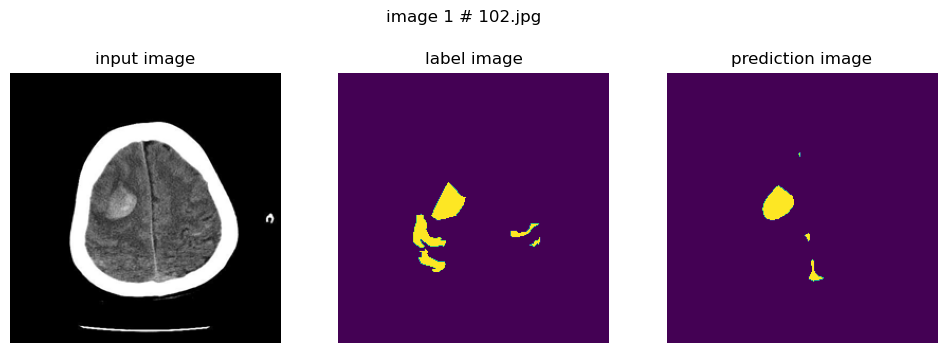

  8%|▊         | 1/13 [00:07<01:28,  7.41s/it, Accuracy=0.984, Jaccard_Score=0.968]

Totally cost: 4.871724605560303
{'F1': array([99.16681725, 52.95918322]), 'Pixel_Accuracy': array([98.36273193, 98.36273193]), 'IoU': array([98.347502  , 36.01669648]), 'MIoU': 0.6718209924195363, 'Precision': array([99.71736415, 40.37433152])}


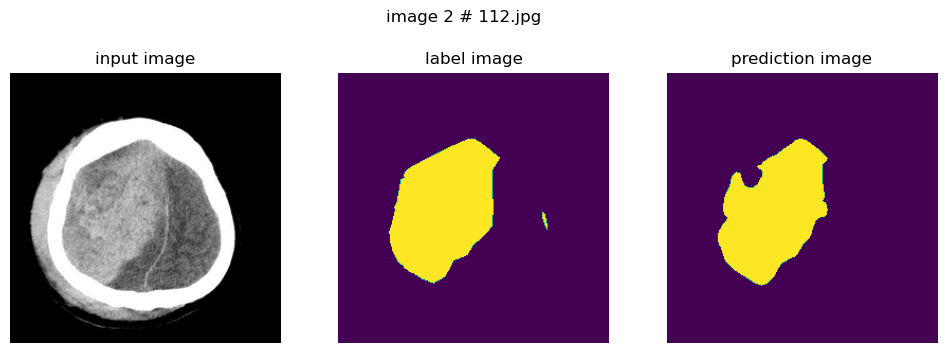

 15%|█▌        | 2/13 [00:07<00:35,  3.21s/it, Accuracy=0.945, Jaccard_Score=0.896]

Totally cost: 0.09302163124084473
{'F1': array([99.06110832, 94.39535576]), 'Pixel_Accuracy': array([98.39172363, 98.39172363]), 'IoU': array([98.13978115, 89.3856999 ]), 'MIoU': 0.9376274052500935, 'Precision': array([99.55598525, 91.67527369])}


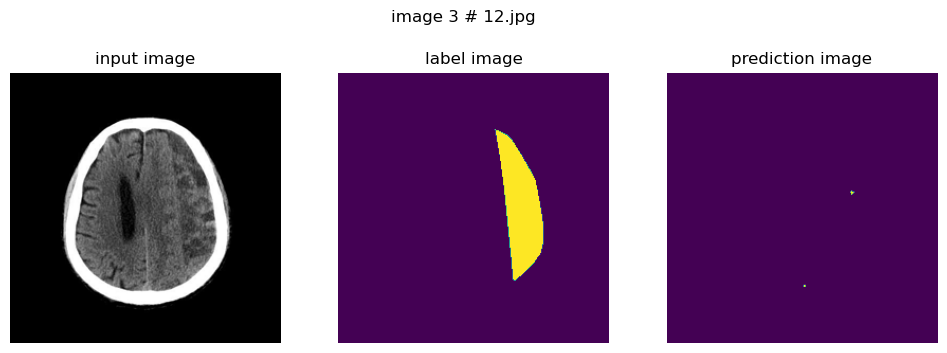

 23%|██▎       | 3/13 [00:08<00:18,  1.87s/it, Accuracy=0.987, Jaccard_Score=0.975]

Totally cost: 0.09502053260803223
{'F1': array([97.17947946,  0.44308989]), 'Pixel_Accuracy': array([94.51446533, 94.51446533]), 'IoU': array([94.51379563,  0.22203719]), 'MIoU': 0.47367916410289407, 'Precision': array([99.99354182,  0.22228397])}


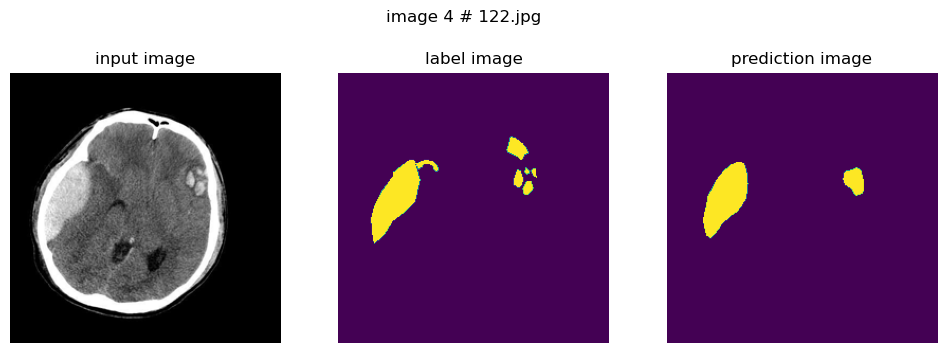

 31%|███       | 4/13 [00:08<00:11,  1.30s/it, Accuracy=0.997, Jaccard_Score=0.994]

Totally cost: 0.09302091598510742
{'F1': array([99.33636792, 81.90635518]), 'Pixel_Accuracy': array([98.7197876, 98.7197876]), 'IoU': array([98.68158461, 69.35719503]), 'MIoU': 0.8401938982279801, 'Precision': array([99.57504836, 76.88259106])}


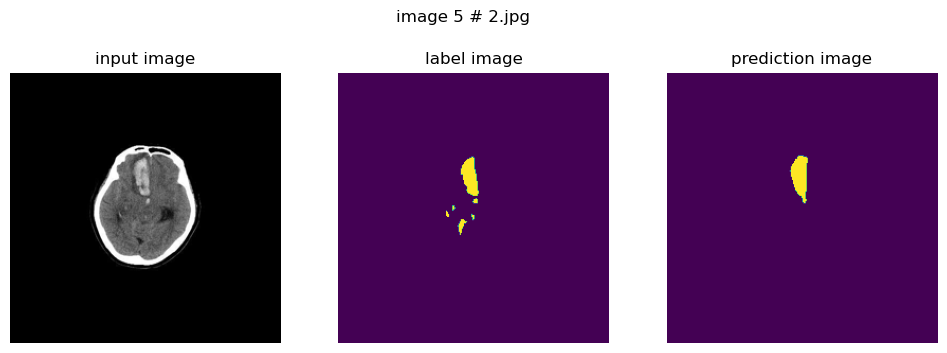

 38%|███▊      | 5/13 [00:08<00:07,  1.07it/s, Accuracy=0.989, Jaccard_Score=0.978]

Totally cost: 0.09301924705505371
{'F1': array([99.84771725, 80.35709273]), 'Pixel_Accuracy': array([99.69787598, 99.69787598]), 'IoU': array([99.6959973, 67.1641791]), 'MIoU': 0.8343008820111568, 'Precision': array([99.86619502, 78.48837194])}


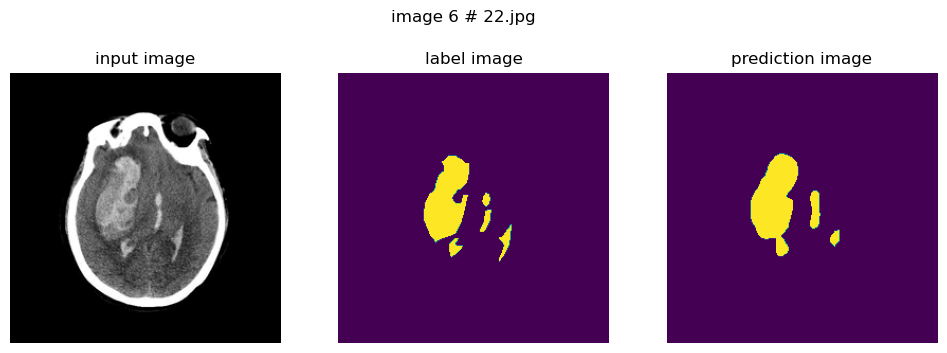

 46%|████▌     | 6/13 [00:09<00:05,  1.40it/s, Accuracy=0.997, Jaccard_Score=0.993]

Totally cost: 0.09402155876159668
{'F1': array([99.42551247, 87.43888944]), 'Pixel_Accuracy': array([98.90136719, 98.90136719]), 'IoU': array([98.85768682, 77.68133912]), 'MIoU': 0.8826951296772741, 'Precision': array([99.15027687, 93.0906389 ])}


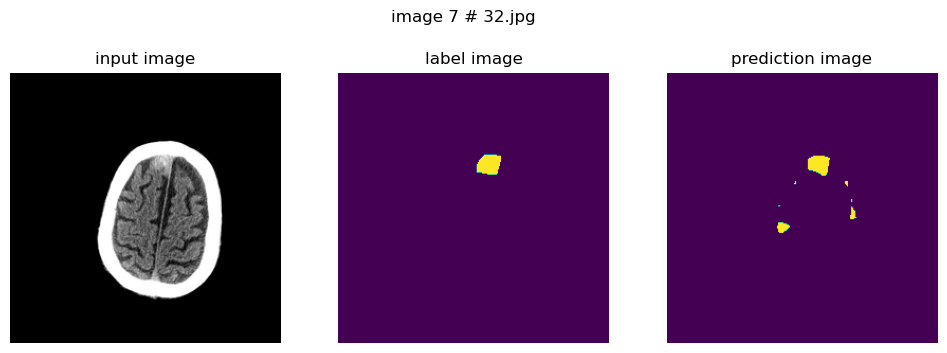

 54%|█████▍    | 7/13 [00:09<00:03,  1.74it/s, Accuracy=0.997, Jaccard_Score=0.995]

Totally cost: 0.10802245140075684
{'F1': array([99.82721191, 72.46017082]), 'Pixel_Accuracy': array([99.65667724, 99.65667724]), 'IoU': array([99.65511956, 56.81381958]), 'MIoU': 0.7823446956814408, 'Precision': array([99.75450709, 81.99445961])}


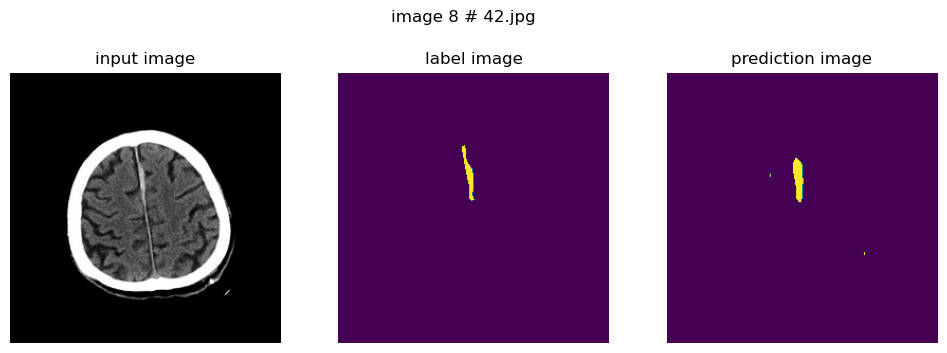

 62%|██████▏   | 8/13 [00:09<00:02,  2.07it/s, Accuracy=0.965, Jaccard_Score=0.933]

Totally cost: 0.09602117538452148
{'F1': array([99.87433148, 68.33971904]), 'Pixel_Accuracy': array([99.74975586, 99.74975586]), 'IoU': array([99.74907817, 51.90615836]), 'MIoU': 0.7582761826302095, 'Precision': array([99.81933153, 79.37219695])}


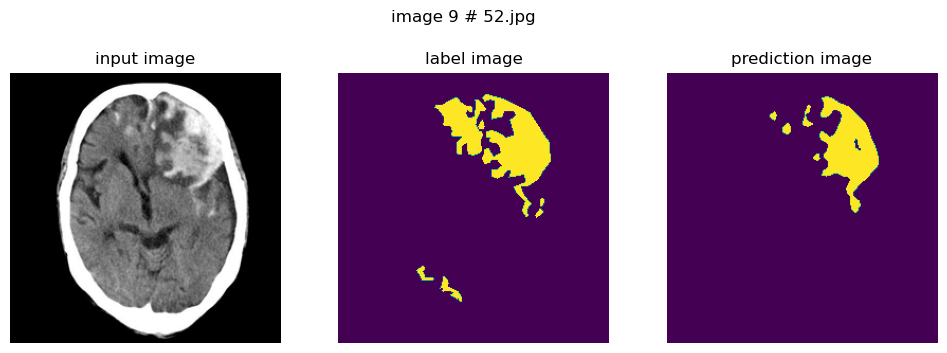

 69%|██████▉   | 9/13 [00:09<00:01,  2.37it/s, Accuracy=0.997, Jaccard_Score=0.994]

Totally cost: 0.09502100944519043
{'F1': array([98.14821869, 72.10779537]), 'Pixel_Accuracy': array([96.52709961, 96.52709961]), 'IoU': array([96.36386874, 56.38175546]), 'MIoU': 0.7637281210163784, 'Precision': array([99.55108103, 59.48241002])}


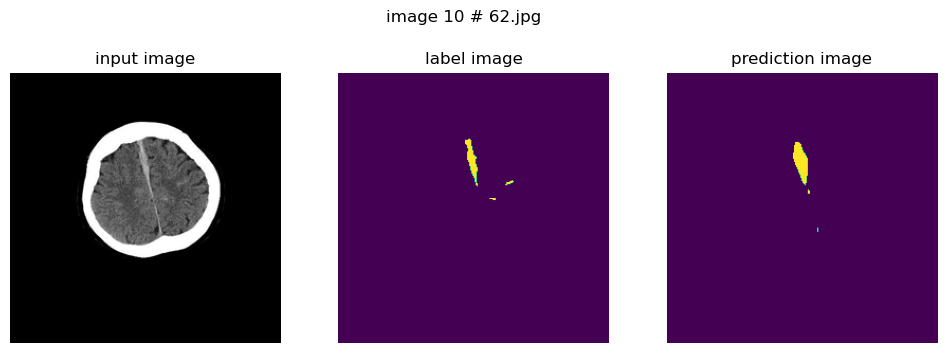

 77%|███████▋  | 10/13 [00:10<00:01,  2.63it/s, Accuracy=0.94, Jaccard_Score=0.886] 

Totally cost: 0.09402108192443848
{'F1': array([99.8466416 , 67.53241885]), 'Pixel_Accuracy': array([99.69482422, 99.69482422]), 'IoU': array([99.69385256, 50.98039216]), 'MIoU': 0.7533712235812767, 'Precision': array([99.76410036, 81.88976346])}


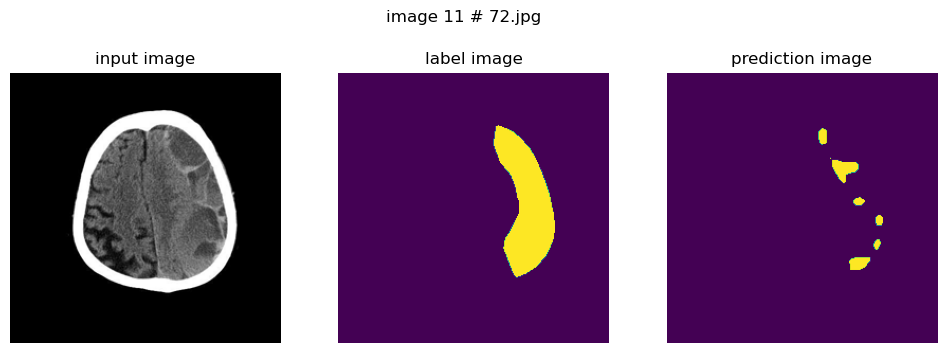

 85%|████████▍ | 11/13 [00:10<00:00,  2.86it/s, Accuracy=0.997, Jaccard_Score=0.995]

Totally cost: 0.09401965141296387
{'F1': array([96.85307465, 26.19400473]), 'Pixel_Accuracy': array([93.96362305, 93.96362305]), 'IoU': array([93.89826326, 15.07084586]), 'MIoU': 0.5448455455676195, 'Precision': array([99.85729517, 15.35768978])}


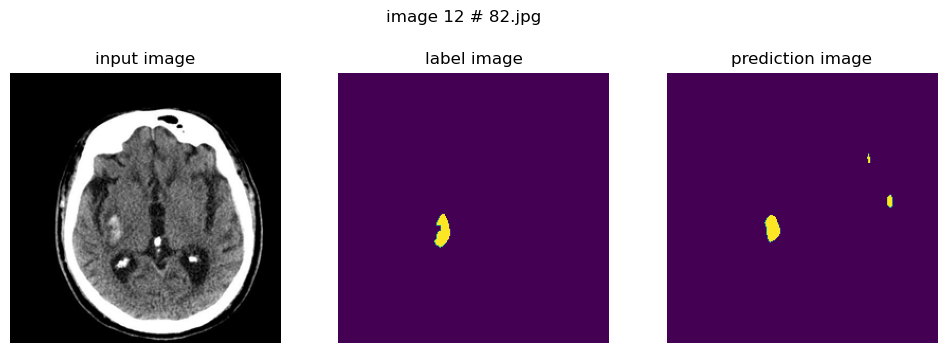

 92%|█████████▏| 12/13 [00:10<00:00,  3.01it/s, Accuracy=0.976, Jaccard_Score=0.953]

Totally cost: 0.09902143478393555
{'F1': array([99.86503034, 71.7948217 ]), 'Pixel_Accuracy': array([99.73144531, 99.73144531]), 'IoU': array([99.73052425, 56.        ]), 'MIoU': 0.7786526212640863, 'Precision': array([99.84058859, 75.67567542])}


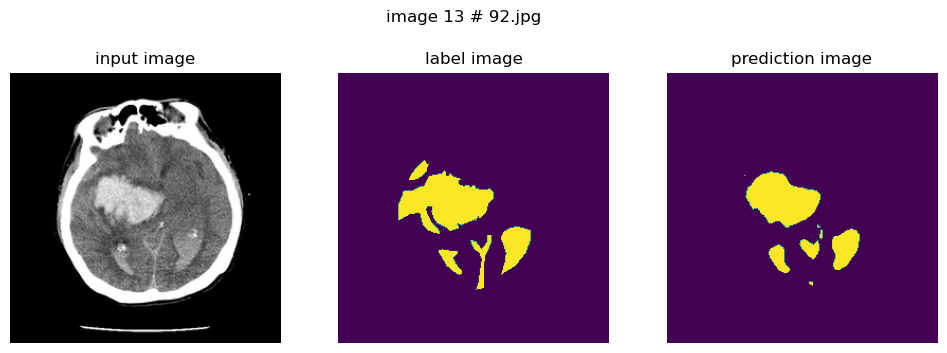

100%|██████████| 13/13 [00:10<00:00,  1.19it/s, Accuracy=0.976, Jaccard_Score=0.953]


Totally cost: 0.0980215072631836
{'F1': array([98.71211685, 80.77759344]), 'Pixel_Accuracy': array([97.58605957, 97.58605957]), 'IoU': array([97.45708223, 67.75377089]), 'MIoU': 0.8260542656386147, 'Precision': array([99.49620099, 72.27658185])}
F1_total: [99.01104832 65.90049924]
fin: {'F1': array([98.71211685, 80.77759344]), 'Pixel_Accuracy': array([97.58605957, 97.58605957]), 'IoU': array([97.45708223, 67.75377089]), 'MIoU': 0.8260542656386147, 'Precision': array([99.49620099, 72.27658185]), 'acc': 0.9811518742487981, 'js': 0.963667851437654}


In [16]:
test_path = output_path + f"{mod_name}_test\\"
test_path = test_path + weight_path[-20:]
print(test_path, AddQKV, f"used RoLA: {TFPreT}")
test(test_loader, model, test_path, num_class, input_path, img_size)

### Check the name of get_local.cache

In [35]:
cache = get_local.cache
print(list(cache.keys()))

['LowMixer.att_fun', 'CSWinAttention.forward']


In [36]:
attention_maps_1 = cache['CSWinAttention.forward']
attention_maps_2 = cache['LowMixer.att_fun']
attn1_layer, attn2_layer = len(attention_maps_1), len(attention_maps_2)
print(attn1_layer, attn2_layer)

3000 7500


In [37]:
attention_maps_2[0].shape
# attention_maps_1[0].shape

(1, 3, 256, 256)

In [43]:
from PIL import Image, ImageDraw
def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()
def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    # draw = ImageDraw.Draw(padded_image)
    # draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask

def visualize_grid_to_grid(att_map, grid_index, image, img_name, path, grid_size=16, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    # print(f"att_map: {att_map.shape}")
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f'image #{img_name} grid {grid_index} attention map')
    fig.tight_layout(h_pad = 2)
    ax[0].imshow(grid_image, cmap='gray')
    ax[0].axis('off')
    
    ax[1].imshow(grid_image, cmap='gray')
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    # save the image
    fig.savefig(f'{path}{img_name[:-4]}_{grid_index}.png', bbox_inches = 'tight',)
# check grid_size
def highlight_grid(image, grid_indexes, grid_size=16):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        # a = image
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

In [39]:
input_path

'.\\dataset\\input_img\\Birds_Species\\'

In [40]:
img_name = "1.jpg"
# brain
# img = Image.open(f"{input_path}JPEGImages\\{img_name}").resize((img_size[0], img_size[1]))
# Bird-100
img = Image.open(f"{input_path}test\\AFRICAN CROWNED CRANE\\{img_name}").resize((img_size[0], img_size[1]))

(256, 256)


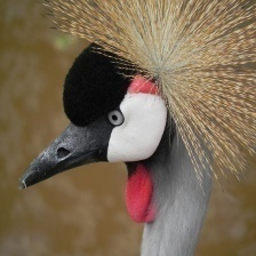

In [41]:
print(img.size)
img

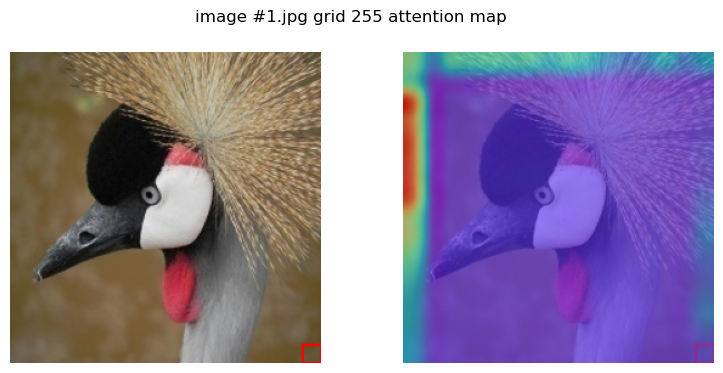

In [44]:
# self-attention map of the '4^th' layer
for num in range(img.size[0]):
    # print(f"grid: {num}")
    visualize_grid_to_grid(attention_maps_2[0][0,4,:,:], num, img, img_name, test_path)
    clear_output(wait = True)

194


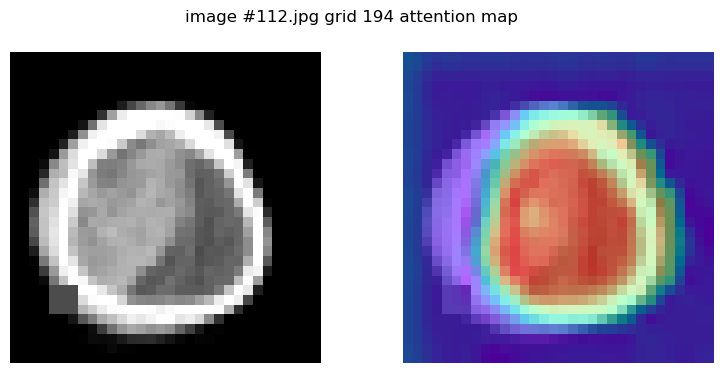

In [213]:

visualize_grid_to_grid(attention_maps_2[7][0,1,:,:], num, img.resize((32, 32)), img_name, test_path)

layer 7397 by origional self-attention


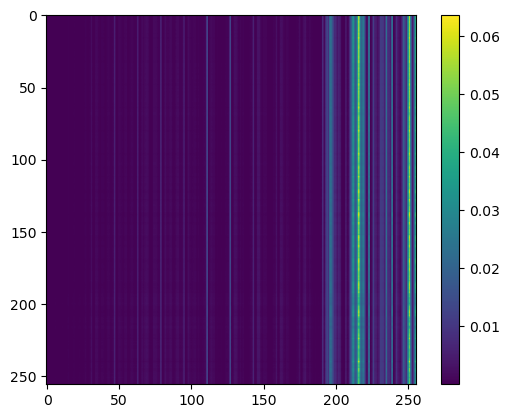

In [45]:
for num in range(attn2_layer):
    print(f"layer {num} by origional self-attention")
    visualize_head(attention_maps_2[num][0, 1])
    time.sleep(0.5)
    clear_output(wait = True)

In [219]:
# 195(0-194)
# 3                         4                       5                       3
# layer(0-2): Head(0-2), layer(3-6): Head(0-6), layer(7-11): Head(0-8), layer(12-14): Head(0-10)
# layer(15-17): 0-2, layer(18-21): 0-6, layer(22-26): 0-8, layer(27-29): 0-10
stage = [3, 7, 12, 15]
inp = 7
for i in range(len(stage)):
    if inp % stage[-1] < stage[i]:
        print(f"stage {i+1}, layer: {inp // stage[-1]}, #{inp} Head")
        break
for i in range(15):
    print(attention_maps_2[i].shape)

stage 3, layer: 0, #7 Head
(1, 3, 256, 256)
(1, 3, 256, 256)
(1, 3, 256, 256)
(1, 7, 256, 256)
(1, 7, 256, 256)
(1, 7, 256, 256)
(1, 7, 256, 256)
(1, 9, 256, 256)
(1, 9, 256, 256)
(1, 9, 256, 256)
(1, 9, 256, 256)
(1, 9, 256, 256)
(1, 11, 64, 64)
(1, 11, 64, 64)
(1, 11, 64, 64)
(1, 11, 64, 64)


In [ ]:
visualize_heads(attention_maps_2[0], cols=4)

In [ ]:
import cv2
def visualize(normalized_heatmap, original=None):
    map_img = np.uint8(normalized_heatmap * 255)
    heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
    if original is not None:
        original_img = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
        img = cv2.addWeighted(heatmap_img, .6, original_img, 0.4, 0)
    else:
        img = heatmap_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    axes.imshow(img)
    plt.show()

In [ ]:
def visualize_img(img, label):
    orig_img_size = img.shape[:2]
    # img = transform(Image.open(img_path))
    _, _, cams = model('transcam', img.unsqueeze(0).cuda())
    cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False).detach()
    cams = cams.cpu().numpy()[0][1:]
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min) / (cam_max - cam_min + 1e-5)
    cam = norm_cam[label]
    visualize(cam, orig_img)

In [ ]:
visualize_img(img, 1)